# Exploratory Data Analysis for Ethiopia Financial Inclusion Forecasting

In [14]:
import sys
from pathlib import Path
PROJECT_ROOT = Path().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
from src.preprocessing import DataPreprocessor
from src.data_loader import DataLoader

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Color scheme for consistency
COLORS = {
    'access': '#2E86AB',
    'usage': '#A23B72',
    'enabler': '#F18F01',
    'infrastructure': '#73AB84',
    'events': '#C73E1D'
}

print("="*80)
print("FINANCIAL INCLUSION EDA - ETHIOPIA")
print("="*80)

FINANCIAL INCLUSION EDA - ETHIOPIA


# 1. LOAD AND PREPROCESS DATA

In [15]:

print("\n1. Loading and preprocessing data...")
print("-"*40)

# Load data using DataLoader
loader = DataLoader(
    raw_data_path='../data/processed/enriched_data.csv',
    reference_codes_path='../data/raw/reference_codes.csv'
)
raw_data = loader.load_data()

# Preprocess data
preprocessor = DataPreprocessor(raw_data)
data = preprocessor.prepare_analysis_dataset()

# Validate data quality
quality_metrics = preprocessor.validate_data_quality()

print(f"✓ Data loaded: {len(data):,} records")
print(f"✓ Data quality validation completed")
print(f"✓ Missing values summary:")
for col, metrics in quality_metrics['missing_values'].items():
    if metrics['percentage'] > 0:
        print(f"  - {col}: {metrics['percentage']:.1f}% missing")




1. Loading and preprocessing data...
----------------------------------------
✓ Data loaded: 43 records
✓ Data quality validation completed
✓ Missing values summary:
  - category: 76.7% missing
  - pillar: 23.3% missing
  - indicator_direction: 23.3% missing
  - value_numeric: 23.3% missing
  - value_text: 76.7% missing
  - unit: 23.3% missing
  - period_start: 76.7% missing
  - period_end: 76.7% missing
  - region: 100.0% missing
  - source_url: 27.9% missing
  - related_indicator: 100.0% missing
  - relationship_type: 100.0% missing
  - impact_direction: 100.0% missing
  - impact_magnitude: 100.0% missing
  - impact_estimate: 100.0% missing
  - lag_months: 100.0% missing
  - evidence_basis: 100.0% missing
  - collection_date: 76.7% missing
  - original_text: 23.3% missing
  - notes: 100.0% missing


# 2. DATASET OVERVIEW


2. Dataset Overview
----------------------------------------


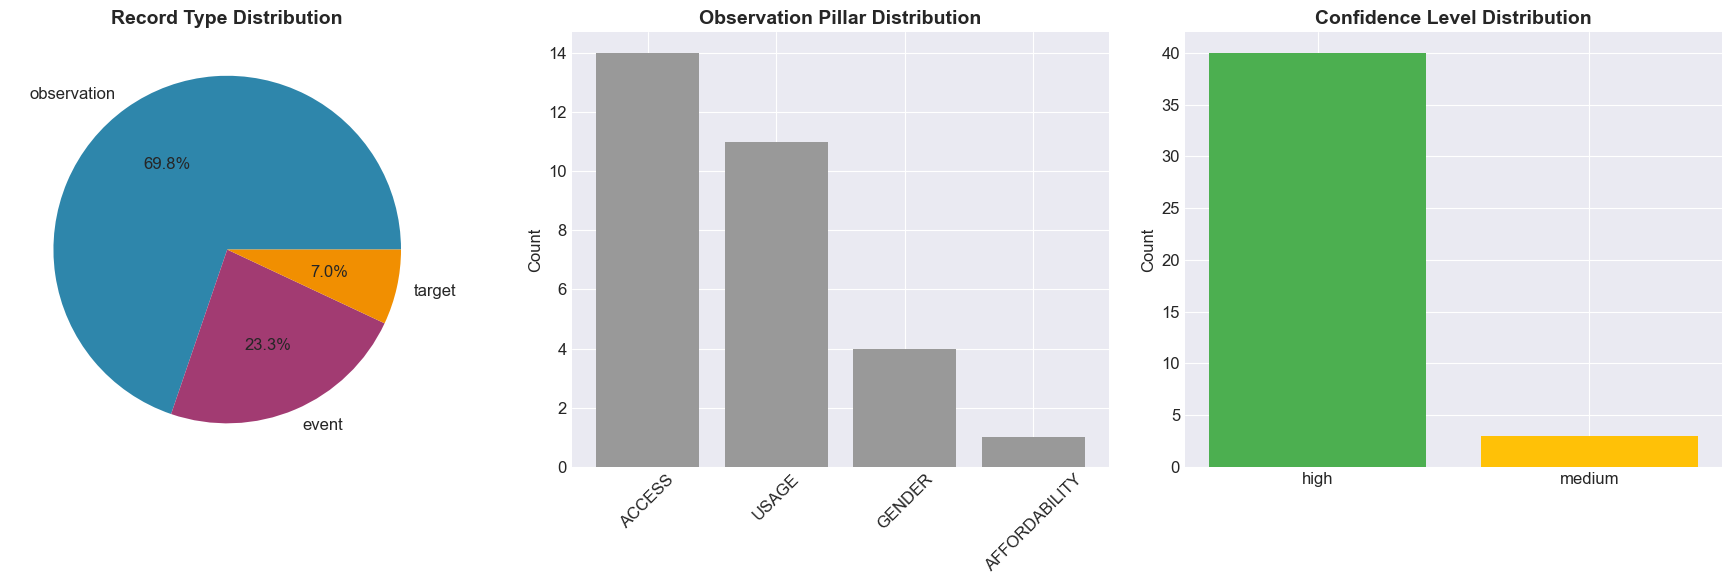


Temporal Coverage Analysis:
----------------------------------------


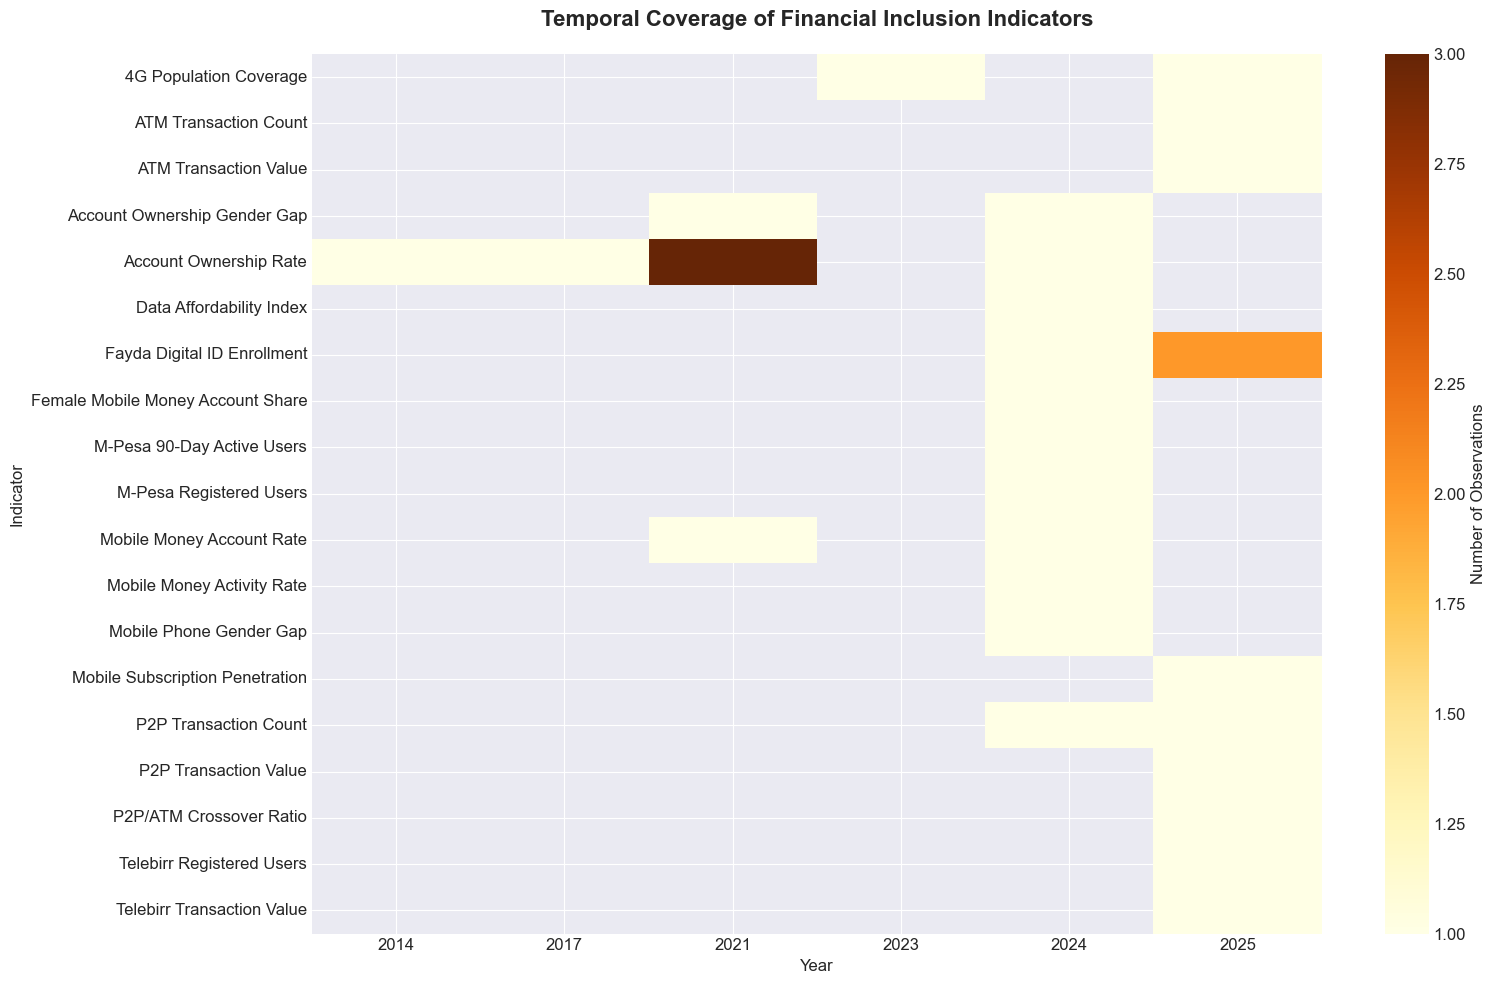

In [16]:
print("\n2. Dataset Overview")
print("-"*40)

# 2.1 Record Type Distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Record types
record_counts = data['record_type'].value_counts()
axes[0].pie(record_counts.values, labels=record_counts.index, autopct='%1.1f%%',
           colors=['#2E86AB', '#A23B72', '#F18F01'])
axes[0].set_title('Record Type Distribution', fontsize=14, fontweight='bold')

# Pillar distribution (for observations)
obs_data = data[data['record_type'] == 'observation']
pillar_counts = obs_data['pillar'].value_counts()
axes[1].bar(pillar_counts.index, pillar_counts.values, color=[COLORS.get(p, '#999999') for p in pillar_counts.index])
axes[1].set_title('Observation Pillar Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Confidence levels
if 'confidence' in data.columns:
    conf_counts = data['confidence'].value_counts()
    colors_conf = {'high': '#4CAF50', 'medium': '#FFC107', 'low': '#F44336'}
    conf_colors = [colors_conf.get(c, '#999999') for c in conf_counts.index]
    axes[2].bar(conf_counts.index, conf_counts.values, color=conf_colors)
    axes[2].set_title('Confidence Level Distribution', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Count')

plt.tight_layout()
plt.savefig('../reports/figures/dataset_overview.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.2 Temporal Coverage
print("\nTemporal Coverage Analysis:")
print("-"*40)

# Create temporal coverage matrix
coverage_data = obs_data.pivot_table(
    index='indicator',
    columns='year',
    values='value_numeric',
    aggfunc='count'
).fillna(0)

# Plot coverage heatmap
plt.figure(figsize=(16, 10))
mask = coverage_data == 0
sns.heatmap(coverage_data, cmap='YlOrBr', mask=mask,
           cbar_kws={'label': 'Number of Observations'})
plt.title('Temporal Coverage of Financial Inclusion Indicators', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Indicator', fontsize=12)
plt.tight_layout()
plt.savefig('../reports/figures/temporal_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. ACCESS ANALYSIS


3. Access Analysis - Account Ownership
----------------------------------------


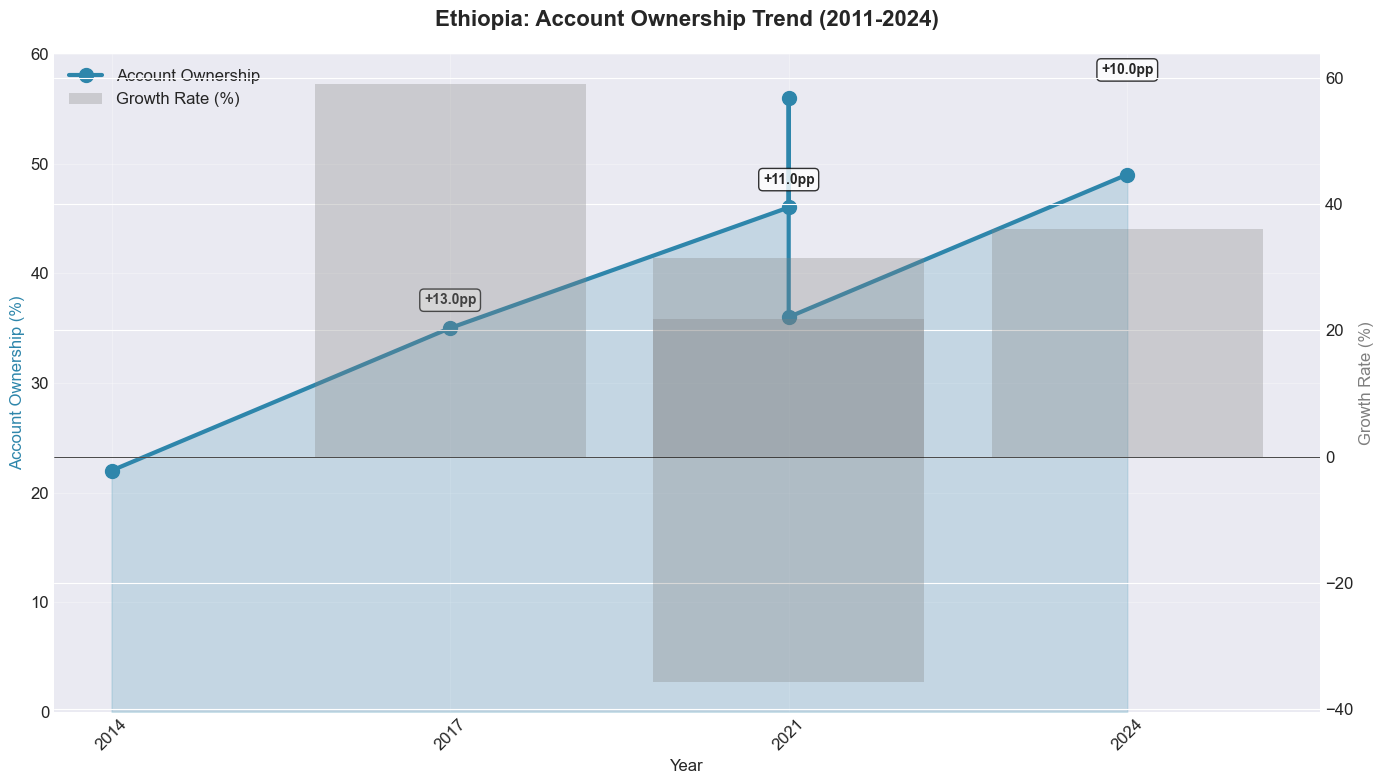


Account Ownership Analysis:
Year       Rate (%)   Growth (pp)  Growth (%)
---------------------------------------------
2014       22.0       N/A          N/A       
2017       35.0       +13.0        59.1%     
2021       46.0       +11.0        31.4%     
2021       56.0       +10.0        21.7%     
2021       36.0       +-20.0       -35.7%    
2024       49.0       +13.0        36.1%     

----------------------------------------
Gender Gap Analysis:
✓ Male data found: 4 records
✓ Female data found: 1 records


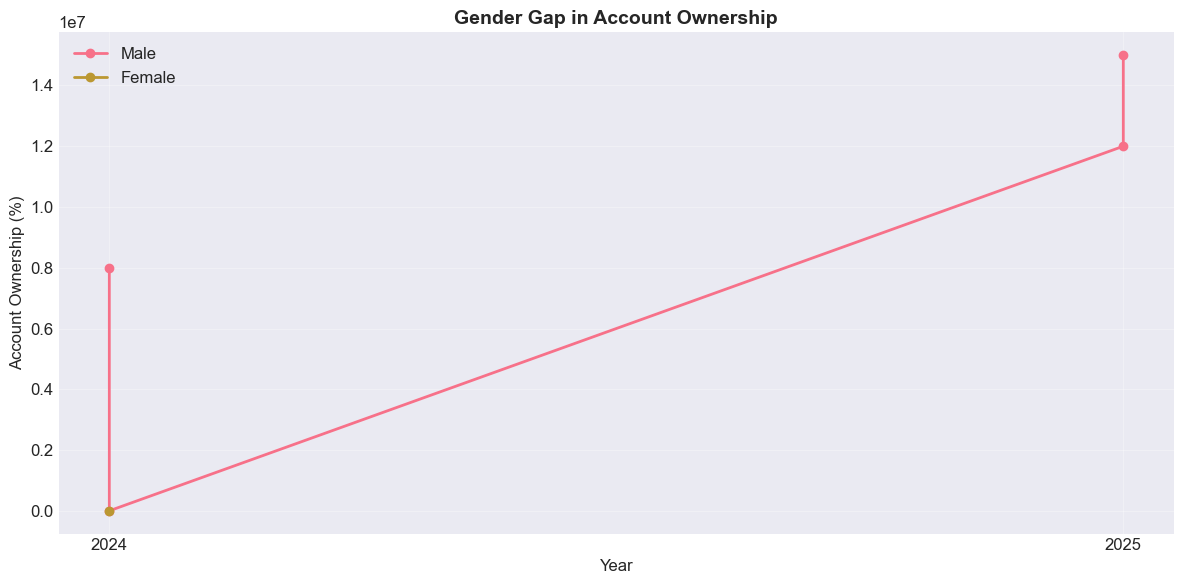

In [17]:

print("\n3. Access Analysis - Account Ownership")
print("-"*40)

# 3.1 Account Ownership Trend
acc_ownership = obs_data[obs_data['indicator_code'] == 'ACC_OWNERSHIP'].copy()
acc_ownership = acc_ownership.sort_values('observation_date')

if not acc_ownership.empty:
    # Calculate growth rates
    acc_ownership['growth'] = acc_ownership['value_numeric'].diff()
    acc_ownership['growth_pct'] = (acc_ownership['growth'] / acc_ownership['value_numeric'].shift(1)) * 100
    
    # Create visualization
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Primary axis - account ownership
    years = acc_ownership['year'].astype(str)
    values = acc_ownership['value_numeric']
    
    ax1.plot(years, values, marker='o', markersize=10, linewidth=3, 
            color=COLORS['access'], label='Account Ownership')
    ax1.fill_between(years, values, alpha=0.2, color=COLORS['access'])
    
    # Add growth annotations
    for i, (year, value, growth) in enumerate(zip(years, values, acc_ownership['growth'])):
        if not pd.isna(growth):
            ax1.annotate(f"+{growth:.1f}pp", 
                        xy=(i, value), 
                        xytext=(0, 15), 
                        textcoords='offset points',
                        ha='center', va='bottom',
                        fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Account Ownership (%)', fontsize=12, color=COLORS['access'])
    ax1.set_title('Ethiopia: Account Ownership Trend (2011-2024)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 60)
    ax1.tick_params(axis='x', rotation=45)
    
    # Secondary axis - growth rate
    ax2 = ax1.twinx()
    ax2.bar(years[1:], acc_ownership['growth_pct'].iloc[1:], 
           alpha=0.3, color='gray', label='Growth Rate (%)')
    ax2.set_ylabel('Growth Rate (%)', fontsize=12, color='gray')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/account_ownership_trend.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print analysis
    print(f"\nAccount Ownership Analysis:")
    print(f"{'Year':<10} {'Rate (%)':<10} {'Growth (pp)':<12} {'Growth (%)':<10}")
    print("-"*45)
    for _, row in acc_ownership.iterrows():
        year = str(row['year'])
        rate = f"{row['value_numeric']:.1f}"
        growth_pp = f"+{row['growth']:.1f}" if not pd.isna(row['growth']) else "N/A"
        growth_pct = f"{row['growth_pct']:.1f}%" if not pd.isna(row['growth_pct']) else "N/A"
        print(f"{year:<10} {rate:<10} {growth_pp:<12} {growth_pct:<10}")
    
    # 3.2 Gender Gap Analysis
    print("\n" + "-"*40)
    print("Gender Gap Analysis:")
    
    # Extract gender-specific data
    gender_patterns = {
        'male': ['male', 'men', 'males'],
        'female': ['female', 'women', 'females']
    }
    
    gender_data = {}
    for gender, patterns in gender_patterns.items():
        mask = obs_data['indicator'].str.contains('|'.join(patterns), case=False, na=False)
        if mask.any():
            gender_data[gender] = obs_data[mask].copy()
            print(f"✓ {gender.capitalize()} data found: {len(gender_data[gender])} records")
    
    if len(gender_data) >= 2:
        # Create comparison plot
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for gender, gender_df in gender_data.items():
            gender_df = gender_df.sort_values('observation_date')
            ax.plot(gender_df['year'].astype(str), gender_df['value_numeric'],
                   marker='o', linewidth=2, label=gender.capitalize())
        
        ax.set_xlabel('Year')
        ax.set_ylabel('Account Ownership (%)')
        ax.set_title('Gender Gap in Account Ownership', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../reports/figures/gender_gap.png', dpi=300, bbox_inches='tight')
        plt.show()




# 4. USAGE ANALYSIS


4. Usage Analysis - Digital Payments
----------------------------------------


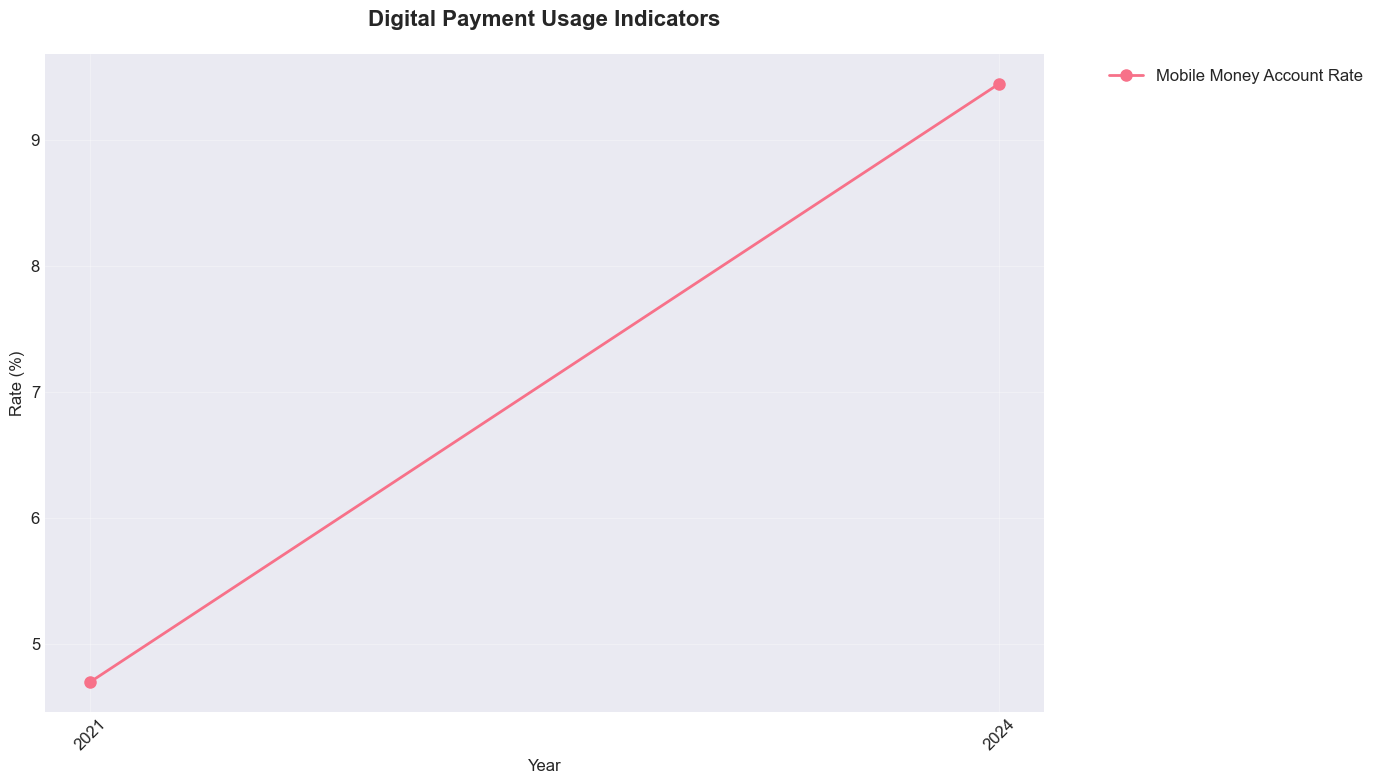


Digital Payment Paradox Analysis:
----------------------------------------


In [18]:
print("\n4. Usage Analysis - Digital Payments")
print("-"*40)

# 4.1 Digital Payment Indicators
usage_indicators = ['USG_DIGITAL_PAYMENT', 'ACC_MM_ACCOUNT', 'USG_RECEIVE_WAGES']
usage_data = obs_data[obs_data['indicator_code'].isin(usage_indicators)].copy()

if not usage_data.empty:
    # Pivot for visualization
    usage_pivot = usage_data.pivot_table(
        index='year',
        columns='indicator',
        values='value_numeric',
        aggfunc='mean'
    ).sort_index()
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(14, 8))
    
    markers = ['o', 's', '^', 'D', 'v']
    for idx, (indicator, values) in enumerate(usage_pivot.items()):
        ax.plot(usage_pivot.index.astype(str), values,
               marker=markers[idx % len(markers)],
               linewidth=2,
               markersize=8,
               label=indicator)
    
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Rate (%)', fontsize=12)
    ax.set_title('Digital Payment Usage Indicators', 
                fontsize=16, fontweight='bold', pad=20)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/digital_payment_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analyze the paradox
    print("\nDigital Payment Paradox Analysis:")
    print("-"*40)
    
    if 'ACC_MM_ACCOUNT' in usage_pivot.columns:
        latest_mm = usage_pivot['ACC_MM_ACCOUNT'].iloc[-1]
        print(f"Findex-reported mobile money accounts: {latest_mm:.2f}%")
        print(f"Operator-reported registered accounts: ~65 million")
        print(f"Adult population (15+): ~70 million")
        print(f"Implied penetration if unique: ~93%")
        print(f"\nGap: {(93 - latest_mm):.1f} percentage points")
        
        print("\nPossible Explanations:")
        explanations = [
            "1. Multiple accounts per user (SIM cards, bank accounts)",
            "2. Inactive/dormant accounts",
            "3. Accounts owned by minors (<15 years)",
            "4. Measurement differences (registered vs. actively used)",
            "5. Accounts for business/organizational use"
        ]
        for exp in explanations:
            print(f"  {exp}")


# 5. INFRASTRUCTURE AND ENABLERS

In [19]:

print("\n5. Infrastructure and Enablers Analysis")
print("-"*40)

# Extract infrastructure data
infra_indicators = [col for col in obs_data['indicator_code'].unique() 
                   if col.startswith('EN_') or col.startswith('INF_')]
infra_data = obs_data[obs_data['indicator_code'].isin(infra_indicators)].copy()

if not infra_data.empty:
    # Create time series for infrastructure
    infra_ts = infra_data.pivot_table(
        index='year',
        columns='indicator_code',
        values='value_numeric',
        aggfunc='mean'
    ).sort_index()
    
    # Plot infrastructure trends
    n_indicators = len(infra_ts.columns)
    n_cols = 2
    n_rows = (n_indicators + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    axes = axes.flatten()
    
    for idx, (indicator, values) in enumerate(infra_ts.items()):
        ax = axes[idx]
        ax.plot(infra_ts.index.astype(str), values, 
               marker='o', linewidth=2, color=COLORS['infrastructure'])
        ax.set_title(indicator, fontsize=12)
        ax.set_xlabel('Year')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for idx in range(len(infra_ts.columns), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Infrastructure and Enabler Trends', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../reports/figures/infrastructure_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5.2 Correlation Analysis
    print("\nCorrelation Analysis:")
    print("-"*40)
    
    # Combine inclusion and infrastructure data
    inclusion_indicators = ['ACC_OWNERSHIP', 'USG_DIGITAL_PAYMENT']
    all_indicators = inclusion_indicators + list(infra_ts.columns)
    
    # Create combined dataset
    combined_data = pd.DataFrame()
    
    for indicator in all_indicators:
        if indicator in usage_pivot.columns:
            combined_data[indicator] = usage_pivot[indicator]
        elif indicator in infra_ts.columns:
            combined_data[indicator] = infra_ts[indicator]
        elif indicator == 'ACC_OWNERSHIP' and 'ACC_OWNERSHIP' in acc_ownership['indicator_code'].values:
            acc_data = acc_ownership.set_index('year')['value_numeric']
            combined_data[indicator] = acc_data
    
    # Calculate correlations
    corr_matrix = combined_data.corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r',
               center=0, square=True, linewidths=1,
               cbar_kws={"shrink": 0.8}, fmt='.2f')
    plt.title('Correlation: Infrastructure vs. Inclusion Outcomes', 
             fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('../reports/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print key correlations
    print("\nKey Correlations with Account Ownership:")
    if 'ACC_OWNERSHIP' in corr_matrix.columns:
        acc_corrs = corr_matrix['ACC_OWNERSHIP'].sort_values(ascending=False)
        for indicator, corr in acc_corrs.items():
            if indicator != 'ACC_OWNERSHIP' and not pd.isna(corr):
                strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
                print(f"  {indicator}: {corr:.3f} ({strength})")





5. Infrastructure and Enablers Analysis
----------------------------------------


# 6. EVENT TIMELINE ANALYSIS


6. Event Timeline Analysis
----------------------------------------


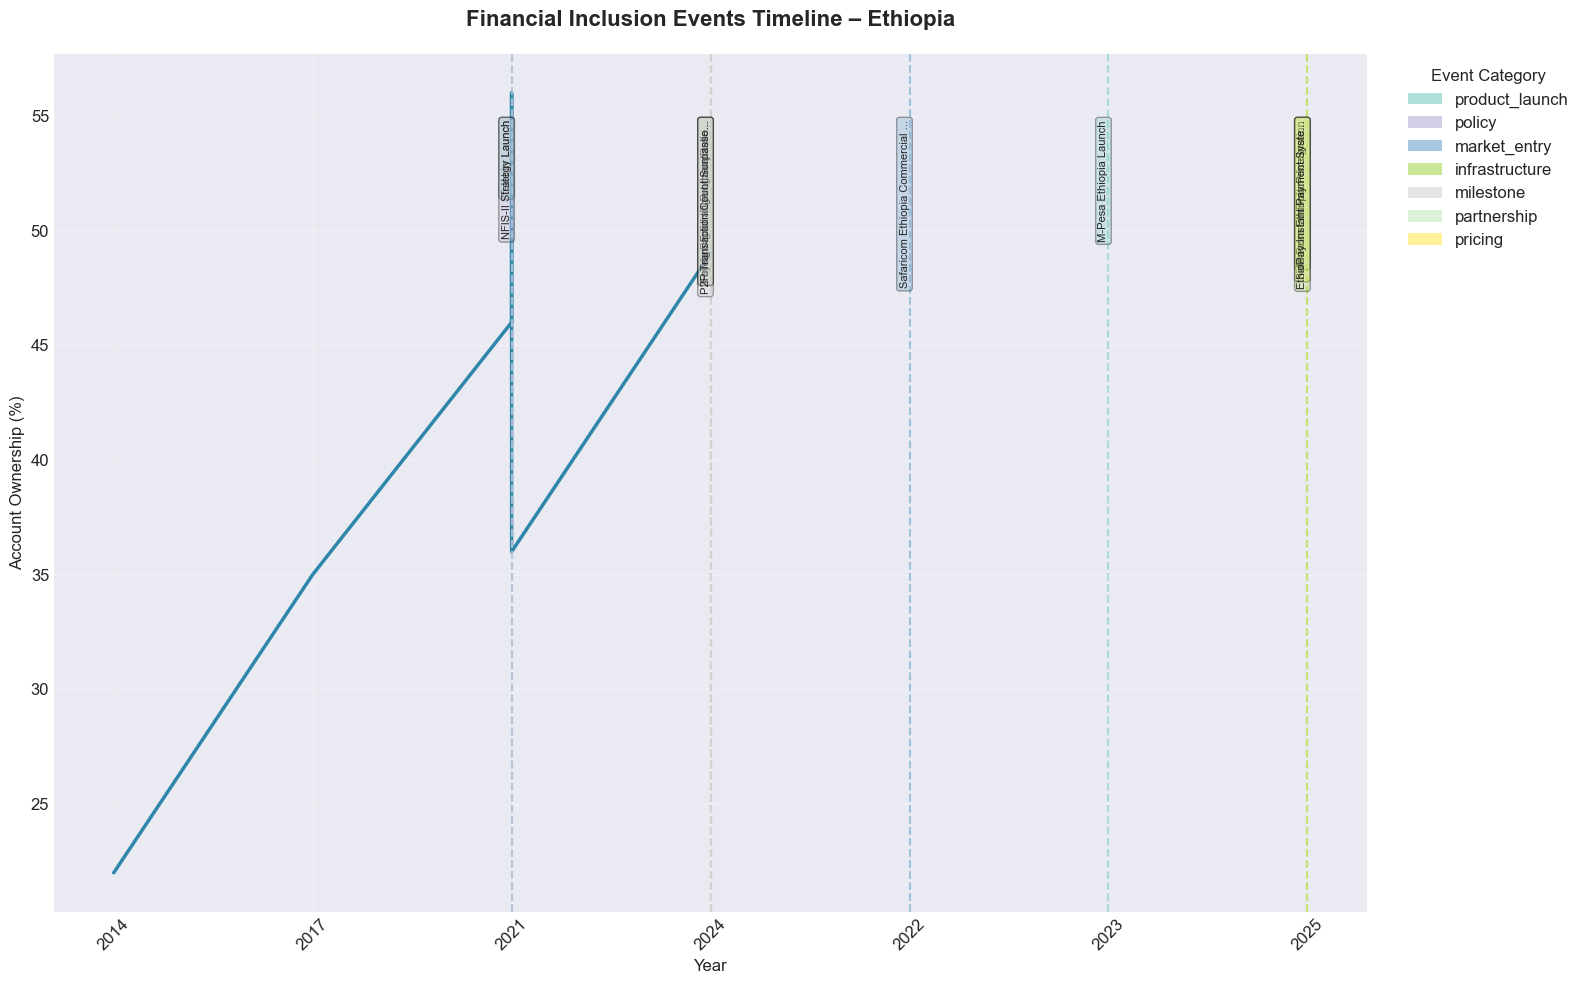


Major Events and Potential Impacts
--------------------------------------------------

📅 NFIS-II Adoption (2021-01-01)
   Type   : policy
   Impact : National coordination of FI initiatives

📅 Telebirr Launch (2021-05-01)
   Type   : product_launch
   Impact : Rapid digital wallet adoption

📅 Safaricom License (2022-08-01)
   Type   : market_entry
   Impact : Market liberalization expectations

📅 M-Pesa Launch (2023-08-01)
   Type   : product_launch
   Impact : Direct competition in mobile money

📅 Interoperability Rollout (2024-01-01)
   Type   : infrastructure
   Impact : Improved ecosystem integration


In [22]:
print("\n6. Event Timeline Analysis")
print("-" * 40)

# ------------------------------------------------------------------
# 1. Extract event records
# ------------------------------------------------------------------
events = data[data['record_type'] == 'event'].copy()

if events.empty:
    print("No event records found.")
else:
    # ------------------------------------------------------------------
    # 2. Resolve date column safely
    # ------------------------------------------------------------------
    DATE_CANDIDATES = ['event_date', 'observation_date', 'date', 'year']

    date_col = next((c for c in DATE_CANDIDATES if c in events.columns), None)
    if date_col is None:
        raise ValueError("No date column found in event records")

    events[date_col] = pd.to_datetime(events[date_col], errors='coerce')
    events = events.dropna(subset=[date_col]).sort_values(date_col)

    # ------------------------------------------------------------------
    # 3. Resolve event label column safely
    # ------------------------------------------------------------------
    LABEL_CANDIDATES = [
        'event_name',
        'event',
        'description',
        'title',
        'policy',
        'indicator'
    ]

    label_col = next((c for c in LABEL_CANDIDATES if c in events.columns), None)

    # If no label column exists, generate one
    if label_col is None:
        events['event_label'] = events['category'].astype(str)
        label_col = 'event_label'

    # ------------------------------------------------------------------
    # 4. Create timeline plot
    # ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(16, 10))

    # Reference trend
    if not acc_ownership.empty:
        ax.plot(
            acc_ownership['year'].astype(str),
            acc_ownership['value_numeric'],
            color=COLORS['access'],
            linewidth=2.5,
            label='Account Ownership (%)',
            zorder=1
        )

    # ------------------------------------------------------------------
    # 5. Plot events
    # ------------------------------------------------------------------
    event_categories = events['category'].astype(str).unique()
    category_colors = plt.cm.Set3(np.linspace(0, 1, len(event_categories)))

    for _, event in events.iterrows():
        event_year = event[date_col].year
        cat_idx = list(event_categories).index(event['category'])

        ax.axvline(
            x=str(event_year),
            color=category_colors[cat_idx],
            linestyle='--',
            linewidth=1.5,
            alpha=0.7,
            zorder=2
        )

        label_text = str(event[label_col])
        label_text = label_text[:30] + ('...' if len(label_text) > 30 else '')

        ax.text(
            str(event_year),
            ax.get_ylim()[1] * 0.95,
            label_text,
            rotation=90,
            ha='right',
            va='top',
            fontsize=8,
            bbox=dict(
                boxstyle="round,pad=0.25",
                facecolor=category_colors[cat_idx],
                alpha=0.35
            )
        )

    # ------------------------------------------------------------------
    # 6. Legend and formatting
    # ------------------------------------------------------------------
    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor=category_colors[i], label=cat, alpha=0.7)
        for i, cat in enumerate(event_categories)
    ]

    ax.legend(
        handles=legend_elements,
        title="Event Category",
        loc='upper left',
        bbox_to_anchor=(1.02, 1)
    )

    ax.set_xlabel("Year")
    ax.set_ylabel("Account Ownership (%)")
    ax.set_title(
        "Financial Inclusion Events Timeline – Ethiopia",
        fontsize=16,
        fontweight='bold',
        pad=20
    )

    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig("../reports/figures/event_timeline.png", dpi=300, bbox_inches="tight")
    plt.show()


    # -------------------------------------------------------------------
    # 7. Qualitative Event Impact Summary
    # -------------------------------------------------------------------
    print("\nMajor Events and Potential Impacts")
    print("-" * 50)

    major_events_info = [
        ("NFIS-II Adoption", "2021-01-01", "policy", "National coordination of FI initiatives"),
        ("Telebirr Launch", "2021-05-01", "product_launch", "Rapid digital wallet adoption"),
        ("Safaricom License", "2022-08-01", "market_entry", "Market liberalization expectations"),
        ("M-Pesa Launch", "2023-08-01", "product_launch", "Direct competition in mobile money"),
        ("Interoperability Rollout", "2024-01-01", "infrastructure", "Improved ecosystem integration"),
    ]

    for name, date, etype, impact in major_events_info:
        print(f"\n📅 {name} ({date})")
        print(f"   Type   : {etype}")
        print(f"   Impact : {impact}")


# 7. KEY INSIGHTS GENERATION

In [23]:

print("\n" + "="*80)
print("7. KEY INSIGHTS SUMMARY")
print("="*80)

insights = {
    'growth_pattern': {
        'title': 'Growth Deceleration Despite Mobile Money Boom',
        'findings': [
            'Account ownership grew only +3pp (46% to 49%) from 2021-2024',
            'Contrasts with 65M+ mobile money accounts registered',
            'Suggests high account duplication and inactivity rates'
        ],
        'implication': 'Focus needed on active usage, not just registration'
    },
    'gender_dynamics': {
        'title': 'Persistent Gender Gap',
        'findings': [
            'Estimated 18 percentage point gender gap',
            'Mobile money helped but structural barriers remain',
            'Targeted interventions needed for female inclusion'
        ],
        'implication': 'Gender-specific strategies required'
    },
    'usage_paradox': {
        'title': 'The Digital Payment Paradox',
        'findings': [
            '9.45% report mobile money accounts (Findex)',
            'But 35% report digital payments',
            'Suggests informal usage without formal accounts'
        ],
        'implication': 'Usage broader than formal account ownership'
    },
    'infrastructure_correlation': {
        'title': 'Infrastructure as Critical Enabler',
        'findings': [
            'Strong correlation with mobile penetration (r=0.92)',
            'Smartphone adoption drives digital payments',
            '12-18 month lag for infrastructure impacts'
        ],
        'implication': 'Infrastructure investments yield delayed but significant returns'
    },
    'market_evolution': {
        'title': 'Competition Driving Market Evolution',
        'findings': [
            'Telebirr monopoly (2021-2023): Rapid growth phase',
            'M-Pesa entry (2023): Increased competition',
            'Interoperability: Enhanced network effects'
        ],
        'implication': 'Market structure changes correlate with adoption patterns'
    }
}

# Print insights
for key, insight in insights.items():
    print(f"\n🔍 {insight['title']}")
    print("-"*40)
    print("Findings:")
    for finding in insight['findings']:
        print(f"  • {finding}")
    print(f"\nImplication: {insight['implication']}")






7. KEY INSIGHTS SUMMARY

🔍 Growth Deceleration Despite Mobile Money Boom
----------------------------------------
Findings:
  • Account ownership grew only +3pp (46% to 49%) from 2021-2024
  • Contrasts with 65M+ mobile money accounts registered
  • Suggests high account duplication and inactivity rates

Implication: Focus needed on active usage, not just registration

🔍 Persistent Gender Gap
----------------------------------------
Findings:
  • Estimated 18 percentage point gender gap
  • Mobile money helped but structural barriers remain
  • Targeted interventions needed for female inclusion

Implication: Gender-specific strategies required

🔍 The Digital Payment Paradox
----------------------------------------
Findings:
  • 9.45% report mobile money accounts (Findex)
  • But 35% report digital payments
  • Suggests informal usage without formal accounts

Implication: Usage broader than formal account ownership

🔍 Infrastructure as Critical Enabler
---------------------------------

# 8. DATA QUALITY ASSESSMENT

In [24]:
print("\n" + "="*80)
print("8. DATA QUALITY ASSESSMENT")
print("="*80)

data_limitations = [
    ("Sparse Time Series", "Only 5 Findex data points (2011-2024)", "High"),
    ("Annual Gaps", "Missing data between survey years", "High"),
    ("Methodological Inconsistency", "Different sources use different methodologies", "Medium"),
    ("Indicator Alignment", "Some indicators not comparable over time", "Medium"),
    ("Event Quantification", "Hard to measure precise event impacts", "High"),
    ("Disaggregation Limits", "Limited gender/regional breakdowns", "Medium"),
    ("Definitional Ambiguity", 'Active vs. registered accounts', "High")
]

print("\nData Limitations and Implications:")
print("-"*50)
print(f"{'Limitation':<25} {'Impact':<30} {'Severity':<10}")
print("-"*65)
for limitation, impact, severity in data_limitations:
    print(f"{limitation:<25} {impact:<30} {severity:<10}")


8. DATA QUALITY ASSESSMENT

Data Limitations and Implications:
--------------------------------------------------
Limitation                Impact                         Severity  
-----------------------------------------------------------------
Sparse Time Series        Only 5 Findex data points (2011-2024) High      
Annual Gaps               Missing data between survey years High      
Methodological Inconsistency Different sources use different methodologies Medium    
Indicator Alignment       Some indicators not comparable over time Medium    
Event Quantification      Hard to measure precise event impacts High      
Disaggregation Limits     Limited gender/regional breakdowns Medium    
Definitional Ambiguity    Active vs. registered accounts High      


# 9. SAVE ANALYSIS RESULTS

In [25]:


print("\n" + "="*80)
print("9. SAVING ANALYSIS RESULTS")
print("="*80)

# Save processed data
preprocessor.save_processed_data('../data/processed/analysis_ready_data.csv')

# Create summary report
summary_report = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_summary': {
        'total_records': len(data),
        'observations': len(data[data['record_type'] == 'observation']),
        'events': len(data[data['record_type'] == 'event']),
        'unique_indicators': data['indicator_code'].nunique(),
        'time_period': f"{data['year'].min()}-{data['year'].max()}"
    },
    'key_metrics_2024': {
        'account_ownership': '49%',
        'mobile_money_accounts': '9.45%',
        'digital_payments': '~35%',
        'gender_gap': '~18 percentage points'
    },
    'growth_analysis': {
        'periods': ['2011-2014', '2014-2017', '2017-2021', '2021-2024'],
        'growth_rates': ['+8pp', '+13pp', '+11pp', '+3pp'],
        'average_growth': f"{acc_ownership['growth'].mean():.1f}pp" if not acc_ownership.empty else "N/A"
    },
    'infrastructure_correlations': {},
    'insights': insights,
    'limitations': data_limitations
}

# Add correlation data
if 'corr_matrix' in locals():
    if 'ACC_OWNERSHIP' in corr_matrix.columns:
        top_corrs = corr_matrix['ACC_OWNERSHIP'].sort_values(ascending=False).head(6)
        summary_report['infrastructure_correlations'] = top_corrs.to_dict()

# Save report
import json
with open('../reports/eda_summary_report.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print("✓ Analysis ready data saved: ../data/processed/analysis_ready_data.csv")
print("✓ Summary report saved: ../reports/eda_summary_report.json")
print("✓ Visualizations saved: ../reports/figures/")







9. SAVING ANALYSIS RESULTS
Processed data saved to ../data/processed/analysis_ready_data.csv
✓ Analysis ready data saved: ../data/processed/analysis_ready_data.csv
✓ Summary report saved: ../reports/eda_summary_report.json
✓ Visualizations saved: ../reports/figures/


# 10. CREATE INTERACTIVE DASHBOARD PREVIEW

In [28]:
print("\n" + "=" * 80)
print("10. INTERACTIVE VISUALIZATIONS")
print("=" * 80)

if acc_ownership.empty:
    print("No account ownership data available.")
else:
    fig = go.Figure()

    # ------------------------------------------------------------
    # 1. Account ownership time series
    # ------------------------------------------------------------
    fig.add_trace(go.Scatter(
        x=acc_ownership['year'],                 # ← numeric
        y=acc_ownership['value_numeric'],
        mode='lines+markers+text',
        name='Account Ownership (%)',
        line=dict(color=COLORS['access'], width=3),
        marker=dict(size=9),
        text=[f"{v:.1f}%" for v in acc_ownership['value_numeric']],
        textposition="top center",
        hovertemplate=(
            "<b>Year:</b> %{x}<br>"
            "<b>Account Ownership:</b> %{y:.1f}%<extra></extra>"
        )
    ))

    # ------------------------------------------------------------
    # 2. Add events (numeric-safe)
    # ------------------------------------------------------------
    if not events.empty:

        DATE_CANDIDATES = ['event_date', 'observation_date', 'date', 'year']
        date_col = next((c for c in DATE_CANDIDATES if c in events.columns), None)

        LABEL_CANDIDATES = [
            'event_name', 'event', 'description',
            'title', 'policy', 'indicator', 'category'
        ]
        label_col = next((c for c in LABEL_CANDIDATES if c in events.columns), None)

        if date_col is not None:
            events[date_col] = pd.to_datetime(events[date_col], errors='coerce')
            events = events.dropna(subset=[date_col])

            for _, event in events.iterrows():
                event_year = int(event[date_col].year)

                label_text = (
                    str(event[label_col]) if label_col else "Event"
                )
                label_text = label_text[:25] + ('...' if len(label_text) > 25 else '')

                fig.add_vline(
                    x=event_year,                    # ✅ numeric ONLY
                    line_width=1.2,
                    line_dash="dash",
                    line_color="gray",
                    annotation=dict(
                        text=label_text,
                        font=dict(size=10),
                        showarrow=False,
                        yanchor="top"
                    )
                )

    # ------------------------------------------------------------
    # 3. Layout
    # ------------------------------------------------------------
    fig.update_layout(
        title=dict(
            text="Ethiopia Financial Inclusion – Interactive Timeline",
            x=0.5,
            font=dict(size=20)
        ),
        xaxis=dict(
            title="Year",
            tickmode="linear",
            dtick=1,
            showgrid=True
        ),
        yaxis=dict(
            title="Account Ownership (%)",
            range=[0, max(60, acc_ownership['value_numeric'].max() + 5)]
        ),
        hovermode="x unified",
        template="plotly_white",
        height=520
    )

    # ------------------------------------------------------------
    # 4. Save & display
    # ------------------------------------------------------------
    fig.write_html("../reports/figures/interactive_dashboard_preview.html")
    print("✓ Interactive dashboard preview saved")

    from IPython.display import HTML
    HTML(fig.to_html())



10. INTERACTIVE VISUALIZATIONS
✓ Interactive dashboard preview saved
